## Import libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import seaborn as sns
import warnings
import scipy.stats as stats
from scipy.stats import f_oneway 
from scipy.stats import chi2_contingency
from sklearn.model_selection import train_test_split


warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)

## Data Preprocessing

### Load data and Redo the Processing that done in EDA

In [2]:
# Read the CSV file into a DataFrame(dfloan)
dfloan = pd.read_csv('../data/loan_data_2007_2014.csv', low_memory=False)

# Dropping unnecessary columns from the dataframe
dfloan = dfloan.drop(columns=['id', 'member_id', 'Unnamed: 0'], axis=1)

# Define a function to map loan status to 'Good Loan' or 'Bad Loan'
def map_loan_status(status):
    """
    Function to map loan status to 'Bad Loan' or 'Good Loan'.
    
    Parameters:
    status (str): The loan status to be mapped.
    
    Returns:
    str: 'Bad Loan' if the status is in the list of default statuses, 'Good Loan' otherwise.
    """
    
    # List of loan statuses that imply a default
    default_statuses = [
        'Charged Off', 
        'Late (31-120 days)', 
        'Late (16-30 days)',
        'Default',
        'Does not meet the credit policy. Status:Charged Off'
    ]
    
    # Return 'Bad Loan' if the status is in the list of default statuses, 'Good Loan' otherwise
    return 'Bad Loan' if status in default_statuses else 'Good Loan'

# Apply the map_loan_status function to each status in the 'loan_status' column
dfloan['loan_status'] = dfloan['loan_status'].apply(map_loan_status)

# Convert the 'issue_d' column to datetime format with 'Oct-14' style dates
dfloan['issue_d'] = pd.to_datetime(dfloan['issue_d'], format='%b-%y')

# Extract the year from the datetime object ad store it in a new column 'years'
dfloan['years'] = dfloan['issue_d'].dt.year


# Define a list of state abbreviations that belong to the West region
West = [
    'CA',  # California
    'NV',  # Nevada
    'UT',  # Utah
    'CO',  # Colorado
    'WY',  # Wyoming
    'MT',  # Montana
    'ID',  # Idaho
    'OR',  # Oregon
    'WA',  # Washington
    'AK',  # Alaska
    'HI'   # Hawaii
]

# Define a list of state abbreviations that belong to the Southwest region
Southwest = [
    'AZ',  # Arizona
    'NM',  # New Mexico
    'TX',  # Texas
    'OK'   # Oklahoma
]

# Define a list of state abbreviations that belong to the Midwest region
Midwest = [
    'ND',  # North Dakota
    'MN',  # Minnesota
    'SD',  # South Dakota
    'NE',  # Nebraska
    'KS',  # Kansas
    'MO',  # Missouri
    'IA',  # Iowa
    'WI',  # Wisconsin
    'IL',  # Illinois
    'IN',  # Indiana
    'OH',  # Ohio
    'MI'   # Michigan
]

# Define a list of state abbreviations that belong to the Southeast region
Southeast = [
    'AR',  # Arkansas
    'LA',  # Louisiana
    'MS',  # Mississippi
    'AL',  # Alabama
    'GA',  # Georgia
    'TN',  # Tennessee
    'KY',  # Kentucky
    'NC',  # North Carolina
    'SC',  # South Carolina
    'WV',  # West Virginia
    'DC',  # District of Columbia
    'VA',  # Virginia
    'DE',  # Delaware
    'FL'   # Florida
]

# Define a list of state abbreviations that belong to the Northeast region
Northeast = [
    'PA',  # Pennsylvania
    'MD',  # Maryland
    'NJ',  # New Jersey
    'NY',  # New York
    'CT',  # Connecticut
    'RI',  # Rhode Island
    'MA',  # Massachusetts
    'NH',  # New Hampshire
    'VT',  # Vermont
    'ME'   # Maine
]

def us_region(state):
    """
    Function to map US state to its corresponding region.

    Parameters:
    state (str): The US state abbreviation.

    Returns:
    str: The region where the state is located.
    """
    # Check if the state is in the West region
    if state in West:
        return 'West'
    # Check if the state is in the Southwest region
    elif state in Southwest:
        return 'Southwest'
    # Check if the state is in the Midwest region
    elif state in Midwest:
        return 'Midwest'
    # Check if the state is in the Southeast region
    elif state in Southeast:
        return 'Southeast'
    # Check if the state is in the Northeast region
    elif state in Northeast:
        return 'Northeast'
    # If the state is not in any of the defined regions, return 'Other'
    else:
        return 'Other'

# Apply the function us_region to 'addr_state' column
# This will create a new column 'region' in the dataframe dfloan
dfloan['region'] = dfloan['addr_state'].apply(us_region)

### Drop Columns with High Missing Values

In [3]:
def dropnan(data, threshold):
    """
    Function to drop columns with missing values above a certain threshold.
    
    Parameters:
    data (DataFrame): The data to be cleaned.
    threshold (float): The threshold proportion of missing values, columns above threshold which will be dropped.
    
    Returns:
    DataFrame: The cleaned data with columns dropped based on the threshold.

    Examples:
    >>> dropnan(data, 0.5)
    """

    # Iterate over each column in the DataFrame
    for column in data.columns:
        
        # Calculate the proportion of missing values in the current column
        missing_values = data[column].isnull().sum() / len(data)

        # if the proportion of missing values is greatwer than the threshold
        if missing_values > threshold:
            
            # Drop the current column from the DataFrame
            data = data.drop(columns=column, axis=1)
    
    # Return the cleaned DataFrame
    return data

In [4]:
# Drop the columns with missing values above the threshold
dfloan_cleaned = dropnan(dfloan, 0.4)

print(dfloan.shape)
print(dfloan_cleaned.shape)

(466285, 74)
(466285, 52)


In [5]:
# potential_bin = ['delinq_2yrs', ]

### Drop Uneccessary Columns

In [6]:
not_necessary_col = ['sub_grade', 'emp_title', 'issue_d', 'pymnt_plan', 'url', 'zip_code', 'title', 'addr_state',
                     'earliest_cr_line', 'inq_last_6mths', 'open_acc', 'pub_rec', 'total_acc', 'initial_list_status', 'out_prncp_inv',
                     'total_pymnt_inv', 'total_rec_late_fee', 'recoveries', 'collection_recovery_fee', 'last_pymnt_d', 'last_credit_pull_d',
                     'collections_12_mths_ex_med', 'application_type', 'policy_code', 'acc_now_delinq', 'years']
dfloan_cleaned1 = dfloan_cleaned.drop(columns=not_necessary_col, axis=1)

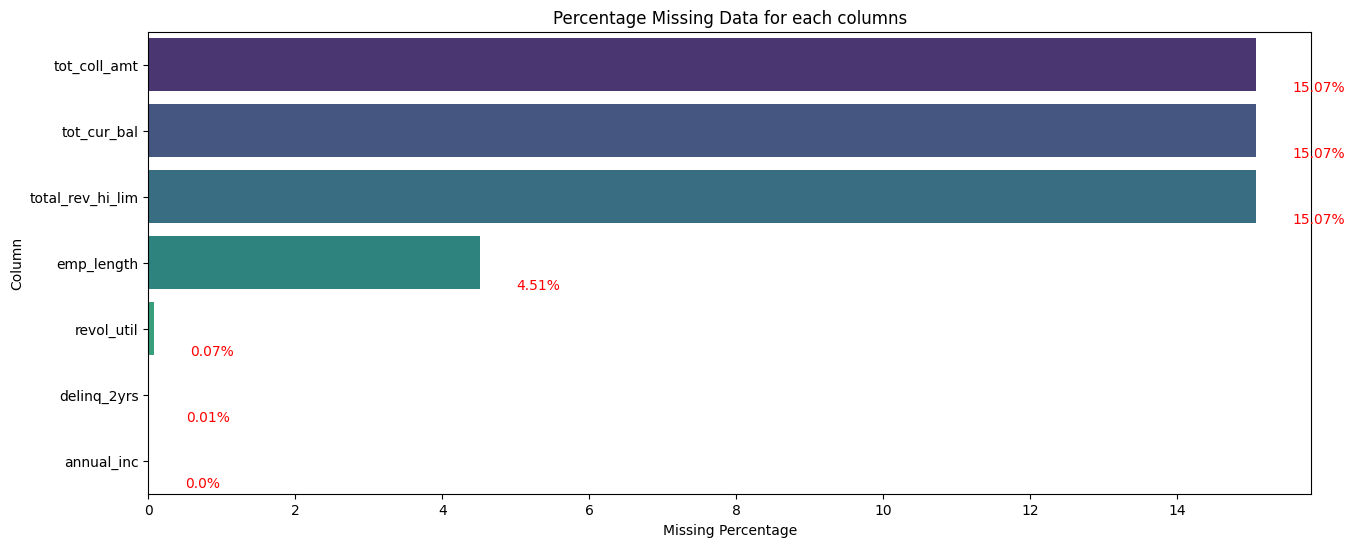

In [7]:
def plot_missing_value(data):
    # Calculate the percentage of missing values in each column
    missing = (data.isnull().sum() / len(data)) * 100
    
    # Filter out the columns that have no missing values
    missing = missing[missing>0]

    # Create a DataFrame from the missing data
    missing_data = pd.DataFrame({'Column': missing.index, 
                                 'Missing%': np.round(missing.values, 2)
    })

    # Sort the DataFrame by the percentage of missing values in descending order
    missing_data = missing_data.sort_values('Missing%', ascending=False)

    # Create a bar plot of the missing data
    plt.figure(figsize=(15, 6))
    ax = sns.barplot(x='Missing%', y='Column', data=missing_data, palette='viridis')

    # Add the percentage of missing data as text on the bars
    for i, v in enumerate(missing_data['Missing%']):
        ax.text(v + 0.5, i + .4, str(v) + '%', color='red')

    # Set the labels and title of the plot
    ax.set_xlabel('Missing Percentage')
    ax.set_title('Percentage Missing Data for each columns')

plot_missing_value(dfloan_cleaned1)


### Train Test Split

In [8]:
X = dfloan_cleaned1.drop(columns=['loan_status'])
y = dfloan_cleaned1[['loan_status']]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1103)

print(f'X train shape: {X_train.shape}')
print(f'y train shape:{y_train.shape}')

print(f'\nX test shape: {X_test.shape}')
print(f'y_test shape: {y_test.shape}')

X train shape: (373028, 25)
y train shape:(373028, 1)

X test shape: (93257, 25)
y_test shape: (93257, 1)


### Impute rest of missing values

In [9]:
# define funtion to fill numerical missing values with median and categorical missing values with mode
def fillnan(data):
    """
    Function to fill missing values in a DataFrame. Numeric columns are filled with the median of the column,
    while categorical/non-numeric columns are filled with the mode.

    Parameters:
    data (DataFrame): The DataFrame to be cleaned.

    Returns:
    DataFrame: The cleaned DataFrame with missing values filled.

    Examples:
    >>> fillnan(data)

    """

    # Iterate over each column in the DataFrame
    for column in data.columns:

        # Check if the current column is numeric
        if data[column].dtype in ['int64', 'float64']:
            # Fill missing values with the median of the column
            data[column] = data[column].fillna(data[column].median())
        else:
            # Fill missing values with the mode of the column
            data[column] = data[column].fillna(data[column].mode()[0])
    # Return the cleaned DataFrame
    return data

# Fill missing values in the train and test
X_train_clean = fillnan(X_train)

X_test_clean = fillnan(X_test)

### Feature Selection

#### Chi Square Test for Categorical Columns

In [10]:
cat_select = X_train_clean.select_dtypes('object')

for column in cat_select.columns:
    contingency_table = pd.crosstab(X_train_clean[column], y_train['loan_status'])
    chi2, p, dof, expected = chi2_contingency(contingency_table)
    if p < 0.05:
        print(f'{column} is dependent on loan_status')
    else:
        print(f'{column} is independent on loan_status')

term is dependent on loan_status
grade is dependent on loan_status
emp_length is dependent on loan_status
home_ownership is dependent on loan_status
verification_status is dependent on loan_status
purpose is dependent on loan_status
region is dependent on loan_status


#### Correlation Matrix for Numerical Columns

<Axes: >

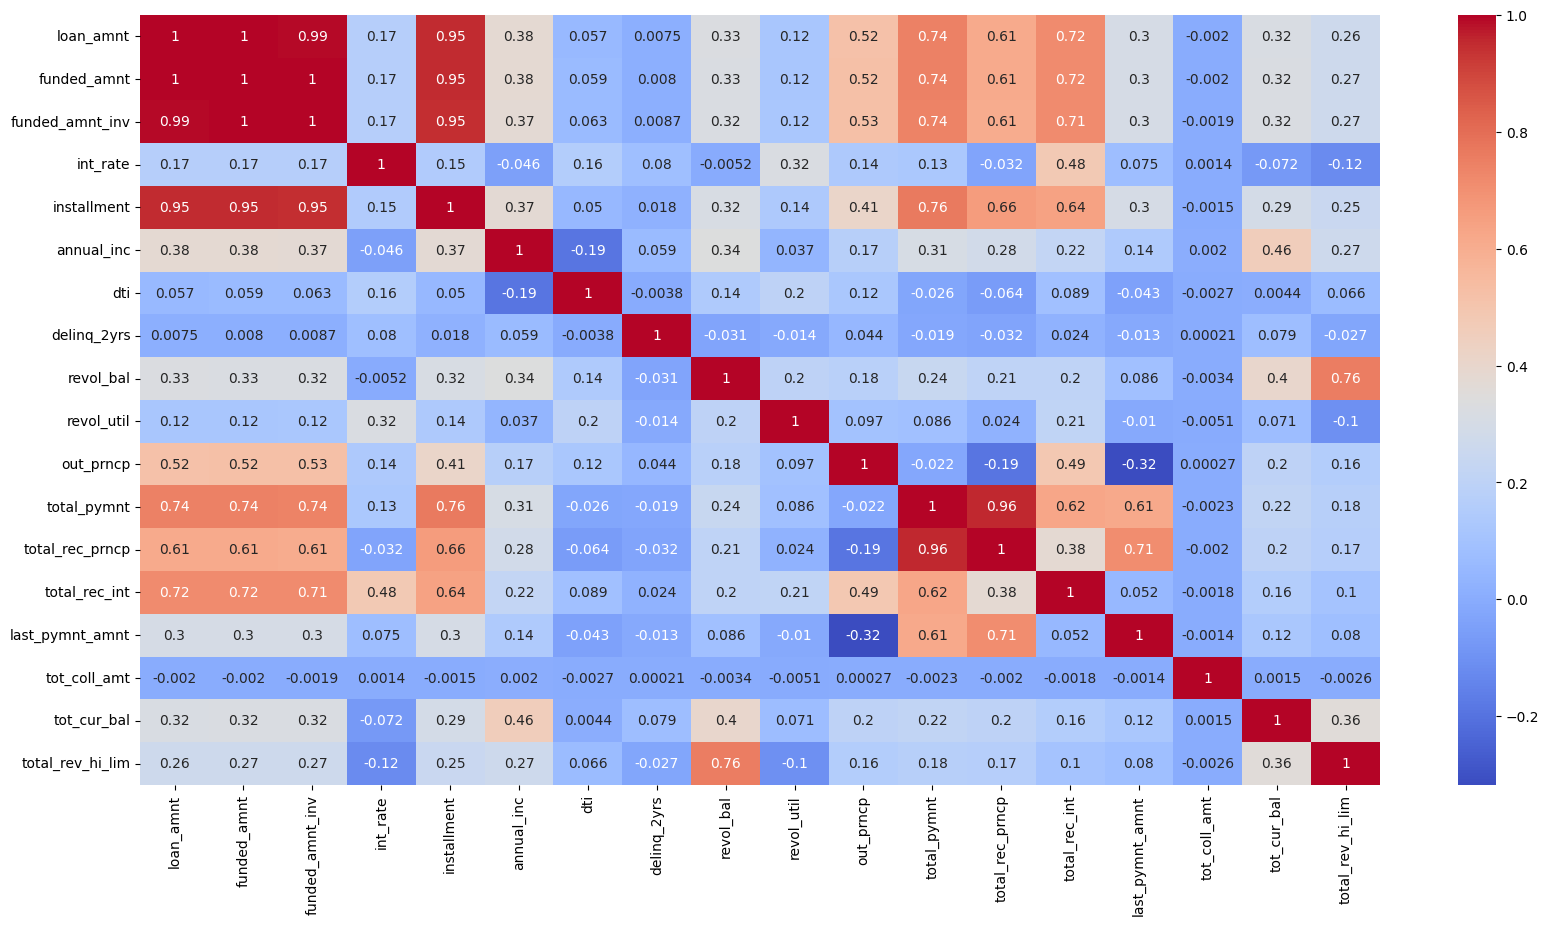

In [11]:
nums = X_train_clean.select_dtypes('number')

dfcorr = nums.corr()

plt.figure(figsize=(20, 10))
sns.heatmap(dfcorr, cmap='coolwarm', annot=True)

In [12]:
# Drop multicollinearity columns
multi_col = ['loan_amnt', 'funded_amnt_inv', 'total_rec_int', 'total_pymnt', 'revol_bal']

X_train_nomulti = X_train_clean.drop(columns=multi_col, axis=1)

X_test_nomulti = X_test_clean.drop(columns=multi_col, axis=1)

#### ANOVA Test for Numerical Columns

<Axes: xlabel='p_value', ylabel='column'>

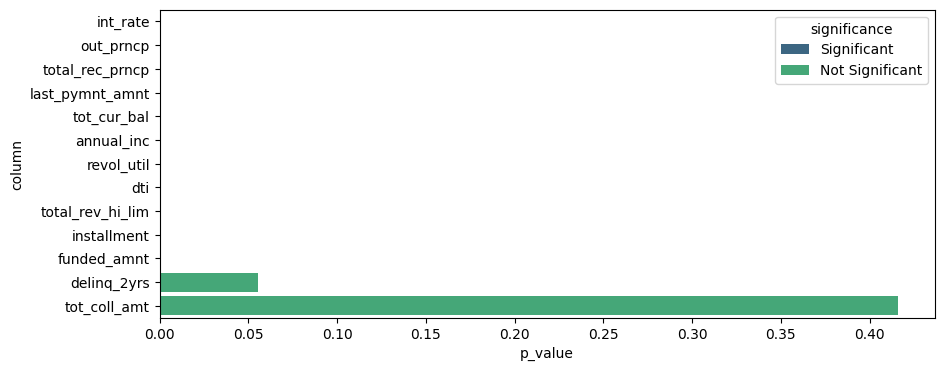

In [13]:
df_temp = pd.concat([X_train_nomulti, y_train], axis=1)
new_nums = df_temp.select_dtypes('number')

anova_results = pd.DataFrame(columns=['column', 'f_score', 'p_value', 'significance'])

# Perform ANOVA for each numerical column with respect to the target
for i, column in enumerate(new_nums.columns):
    # Separate the data based on the categories in the target
    good = df_temp[column][df_temp['loan_status'] == 'Good Loan']
    bad = df_temp[column][df_temp['loan_status'] == 'Bad Loan']
    
    # Perform the ANOVA test
    f_statistic, p_value = f_oneway(good, bad)

    # Determine the significance
    if p_value < 0.05:
        significance = 'Significant'
    else:
        significance = 'Not Significant'
    
    # Append the results to the DataFrame
    anova_results.loc[i] = [column, f_statistic, p_value, significance]

anova_results = anova_results.sort_values('p_value')

plt.figure(figsize=(10, 4))
sns.barplot(x='p_value', y='column', hue='significance', data=anova_results, palette='viridis')

`delinq_2yrs` and `tot_coll_amt` are not significant in ANOVA test, so we can drop them.

In [14]:
not_sig = ['delinq_2yrs', 'tot_coll_amt']
X_train_selected = X_train_nomulti.drop(columns=not_sig, axis=1)

X_test_selected = X_test_nomulti.drop(columns=not_sig, axis=1)

In [15]:
# X_test_clean = fillnan(X_test)

# X_test_nomulti = X_test_clean.drop(columns=multi_col, axis=1)

# X_test_selected = X_test_nomulti.drop(columns=not_sig, axis=1)

### Feature Encoding

In [16]:
X = dfloan_cleaned1.drop(columns=['loan_status'])
y = dfloan_cleaned1[['loan_status']]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1103)

# Fill missing values in the train and test
X_train_clean = fillnan(X_train)

X_test_clean = fillnan(X_test)

# Drop multicollinearity columns
multi_col = ['loan_amnt', 'funded_amnt_inv', 'total_rec_int', 'total_pymnt', 'revol_bal']

X_train_nomulti = X_train_clean.drop(columns=multi_col, axis=1)

X_test_nomulti = X_test_clean.drop(columns=multi_col, axis=1)

not_sig = ['delinq_2yrs', 'tot_coll_amt']
X_train_selected = X_train_nomulti.drop(columns=not_sig, axis=1)

X_test_selected = X_test_nomulti.drop(columns=not_sig, axis=1)


In [17]:
map_target = {
    'Good Loan': 0,
    'Bad Loan': 1
}

y_train = y_train['loan_status'].map(map_target)

y_test = y_test['loan_status'].map(map_target)

In [18]:
from sklearn.pipeline import Pipeline
# from imblearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression
from imblearn.over_sampling import SMOTE

# Define the numerical features to be scaled
numerical_feats = X_train_selected.select_dtypes('number').columns

# Define the categorical features to be encoded
categorical_feats = X_train_selected.select_dtypes('object').columns

# Create a pipeline to scale the numerical features
numerical_pipeline = Pipeline([
    ('scaler', StandardScaler())
])

# Create a pipeline to encode the categorical features
categorical_pipeline = Pipeline([
    ('encoder', OneHotEncoder(drop='first', handle_unknown='ignore'))
])

# Combine transformers using ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('nums', numerical_pipeline, numerical_feats),
        ('cats', categorical_pipeline, categorical_feats)
    ]
)

# Create a pippeline that combines the preprocessing steps and the logistic regression model
pipe_model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(class_weight='balanced'))
])

In [19]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_auc_score
from sklearn.model_selection import StratifiedKFold, cross_val_score


def evaluate_model(model, X_train, y_train, X_test, y_test):
    # Predict the target values for the training set
    y_train_pred = model.predict(X_train)

    # Calculate the evaluation metrics for the training set
    accuracy_train = accuracy_score(y_train, y_train_pred)
    precision_train = precision_score(y_train, y_train_pred)
    recall_train = recall_score(y_train, y_train_pred)
    f1_train = f1_score(y_train, y_train_pred)
    roc_auc_train = roc_auc_score(y_train, model.predict_proba(X_train)[:, 1])

    # Predict the target values for the test set
    y_test_pred = model.predict(X_test)

    # Calculate the evaluation metrics for the test set
    accuracy_test = accuracy_score(y_test, y_test_pred)
    precision_test = precision_score(y_test, y_test_pred)
    recall_test = recall_score(y_test, y_test_pred)
    f1_test = f1_score(y_test, y_test_pred)
    roc_auc_test = roc_auc_score(y_test, model.predict_proba(X_test)[:, 1])

    # Print the evaluation metrics
    print(f"Training Accuracy:{accuracy_train:.2f}")
    print(f"Test Accuracy: {accuracy_test:.2f}")

    print(f"\nTraining Precision: {precision_train:.2f}")
    print(f"Test Precision: {precision_test:.2f}")

    print(f"\nTraining Recall: {recall_train:.2f}")
    print(f"Test Recall: {recall_test:.2f}")

    print(f"\nTraining F1 Score: {f1_train:.2f}")
    print(f"Test F1 Score: {f1_test:.2f}")

    print(f"\nTraining ROC AUC Score: {roc_auc_train:.2f}")
    print(f"Test ROC AUC Score: {roc_auc_test:.2f}")

    kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=1103)

    cv_scores = cross_val_score(model, X_train, y_train, cv=kfold, scoring='roc_auc')

    print(f"\nMean ROC AUC Score (CV): {cv_scores.mean():.2f}")

    # Plot the confusion matrix
    cm = confusion_matrix(y_test, y_test_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='viridis', cbar=False, annot_kws={'fontsize': 15})
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show()

Training Accuracy:0.97
Test Accuracy: 0.97

Training Precision: 0.91
Test Precision: 0.91

Training Recall: 0.83
Test Recall: 0.83

Training F1 Score: 0.87
Test F1 Score: 0.87

Training ROC AUC Score: 0.97
Test ROC AUC Score: 0.97

Mean ROC AUC Score (CV): 0.97


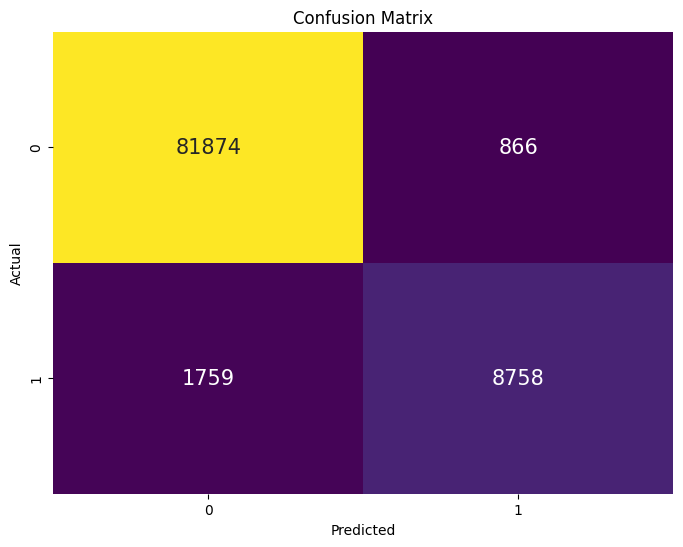

In [20]:
# fit the model
pipe_model.fit(X_train_selected, y_train)

evaluate_model(pipe_model, X_train_selected, y_train, X_test_selected, y_test)

In [21]:
# X_test_clean = fillnan(X_test)